**IMPORT LIBRARIES AND IMAGES**

In [1]:
'''
SIGNS DETECTION - PROJECT MADE BY J. DAVID VELASQUEZ
--------------------------------------------------------------------------
# Let's import a few libraries that will be needed later in the code.
'''
import cv2
import numpy as np
from   matplotlib import pyplot as plt
from   google.colab.patches import cv2_imshow
from   google.colab import drive
import os
import re
from   tqdm import tqdm
import os
from   PIL import Image
import tensorflow.keras as K
import tensorflow as tf
from   keras.layers import LeakyReLU
from   sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import matthews_corrcoef
from keras.models import load_model


# IMAGE RESOLUTION USED IN THIS PROJECT IS 256X256 PIXELS
drive.mount('/content/drive')
dim = 256


Mounted at /content/drive


In [2]:
# Here we count how many elements are in each image folder (dataset)

def contar_imagenes_en_carpeta(ruta_carpeta):
    # Lista todos los archivos en la carpeta
    # List all files in the given folder
    archivos = os.listdir(ruta_carpeta)

    # Filters files with a specific extension
    imagenes = [archivo for archivo in archivos if archivo.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]

    # stores the image quantity
    cantidad_imagenes = len(imagenes)

    return cantidad_imagenes

# Folder directory in Google Drive.
ruta_carpeta = '/content/drive/MyDrive/Signs_Preproc/stop/'

# Let's call the image counter function and print results
cantidad_imagenes = contar_imagenes_en_carpeta(ruta_carpeta)

print(f'La carpeta "Stop" contains {cantidad_imagenes} images.')

cantidad_imagenes = contar_imagenes_en_carpeta('/content/drive/MyDrive/Signs_Preproc/not_stop/')

print(f'La carpeta "Not_Stop" contains {cantidad_imagenes} images.')

La carpeta "Stop" contains 231 images.
La carpeta "Not_Stop" contains 229 images.


In [3]:
# Let's create two arrays that will contain the images and labels.
data = []
data_y = []

# Here we read each file in the folder "Stop" (CLASS 0) and save it into the
# data array.

# In this case we list all the files with jpg, png, JPG and jpeg format, after
# this we filter and start searching for the given files.

contenido= os.listdir("/content/drive/MyDrive/Signs_Preproc/stop")
r= re.compile("\.(jpg|png|JPG|jpeg)", re.IGNORECASE)
coments= list(filter(r.search,contenido))
A= os.path.join("/content/drive/MyDrive/Signs_Preproc/stop/"+coments[0])
for i in tqdm(coments):
  path=os.path.join("/content/drive/MyDrive/Signs_Preproc/stop/"+i)
  im = cv2.imread(path)
  #im = cv2.resize(cv2.imread(path), (dim, dim),interpolation=cv2.INTER_AREA)
  data.append(im)
  data_y.append(0)


100%|██████████| 231/231 [00:03<00:00, 58.43it/s] 


In [5]:
# Here we repeat the process but in this case with the folder
# "not stop" (CLASS 1)


contenido= os.listdir("/content/drive/MyDrive/Signs_Preproc/not_stop")
r= re.compile("\.(jpg|png|JPG|jpeg)", re.IGNORECASE)
coments= list(filter(r.search,contenido))
A= os.path.join("/content/drive/MyDrive/Signs_Preproc/not_stop/"+coments[0])
for i in tqdm(coments):
# Declaracion de path de imagenes
  path=os.path.join("/content/drive/MyDrive/Signs_Preproc/not_stop/"+i)
  im = cv2.imread(path)
  #im = cv2.resize(cv2.imread(path), (dim, dim),interpolation=cv2.INTER_AREA)
  data.append(im)
  data_y.append(1)

100%|██████████| 229/229 [00:02<00:00, 85.11it/s] 


**DATA PREPROCESSING**

In [6]:
# In this section we normalize the data by scaling it to 8 bits and dividing
# each number by 255. This ensures that our data will be between 0 and 1.

data = np.round(((np.array(data).astype(np.uint8))/255.0),decimals = 3)
data_y = np.array(data_y).astype(np.uint8)

In [7]:
# Let's proof that our data have the same dimension.

if(data.shape[0] == data_y.shape[0]):
  print("All correct, they have same dimensions: "+str(data.shape[0])+" and "+str(data_y.shape[0]))

All correct, they have same dimensions: 460 and 460


In [8]:
# Here we split the dataset with the commonly used library from Sklearn.

X_train, X_test, y_train, y_test = train_test_split(data, data_y, test_size=0.2, random_state=42, shuffle = True)
inputs = K.Input(shape=(dim, dim, 3))

In [9]:
# Checking data dimensions...
X_train.shape

(368, 384, 384, 3)

**MODEL GENERATION FUNCTION**

In [10]:
import numpy as np
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer
import keras as K
import tensorflow as tf
from sklearn.metrics import log_loss
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Firsly we clear the session making sure that there is no other Keras session
# running in the background.

# After this, we add a callback function that will allow us to find the best
# model in each Cross Validation Fold.

K.backend.clear_session()
early_stopping = EarlyStopping(monitor='val_loss', patience=150, min_delta=0,
                               restore_best_weights=True, verbose=1,
                               start_from_epoch=20, mode = "min")

# Create a function that calls the ResNet50.

'''
Here we add a sequential model by using Transfer Learning based on a Resnet50.

In this case we used the formula to get an approximate number of neurons in
hidden layers:
N_h = (4N_i^2 + 3)/(N_i^2 - 8), where:
  N_i : Size of input vector, in this case 2048. You can see this info further
  when we call the model summary.

  Source: Sheela K. Deepa, S.N (2013).
  https://www.researchgate.net/figure/Basic-approaches-for-determining-the-
  number-of-neurons-in-a-neural-network_tbl1_347287055
'''

def create_model():
  model = K.models.Sequential()
  resnet = K.applications.ResNet50(weights='imagenet',
             include_top=False, input_tensor=inputs)

  for layer in resnet.layers[:170]:
    layer.trainable = False

  model = K.models.Sequential()
  model.add(resnet)
  model.add(K.layers.GlobalAveragePooling2D())
  model.add(K.layers.BatchNormalization())
  model.add(K.layers.Dense(1024, activation='LeakyReLU'))
  model.add(K.layers.Dropout(0.3))
  model.add(K.layers.Dense(512, activation='LeakyReLU'))
  model.add(K.layers.Dropout(0.2))
  model.add(K.layers.BatchNormalization())
  model.add(K.layers.Dense(256, activation='LeakyReLU'))
  model.add(K.layers.Dropout(0.1))
  model.add(K.layers.BatchNormalization())
  model.add(K.layers.Dense(128, activation='LeakyReLU'))
  model.add(K.layers.Dropout(0.1))
  model.add(K.layers.BatchNormalization())
  model.add(K.layers.Dense(1, activation='sigmoid'))

  model.compile(loss='binary_crossentropy',
                optimizer=K.optimizers.Adagrad(learning_rate=1e-4),
                metrics=['accuracy'])

  return model

# In this line we can see that the output in the convolution layers is 2048, so
# we can use this number to calculate the previous formula.

model = create_model()
model.summary()

94765736/94765736 [==============================] - 2s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                       

**CROSS VALIDATION**

In [ ]:
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import make_scorer
from keras.callbacks import EarlyStopping


# Clear Keras session to avoid cumulative memory issues
K.backend.clear_session()

# Define an array to store model data
b_model = []


# Set up cross-validation with StratifiedKFold
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)  # You can adjust the number of splits as needed

for train_index, test_index in cv.split(X_train, y_train):
    # Split the training set into training and validation
    X_train_fold, X_val_fold = X_train[train_index], X_train[test_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[test_index]

    # Create the model
    model = create_model()

    # Train the model with early stopping and checkpoint
    model.fit(X_train_fold, y_train_fold, epochs=1200, batch_size=6, verbose=1,
              validation_data=(X_val_fold, y_val_fold),
              callbacks=[early_stopping])

    b_model.append(model)


**CHOOSING THE BEST MODEL**

In [ ]:
'''
In this section, we use the Matthews correlation coefficient as our primary
performance indicator, mainly because this tester gives us a general result
without depending on each class performance, takes into account every feature
in the confusion matrix and is robust against class imabalances.
'''
MCC = []

for i in range(len(b_model)):
  MCC.append( matthews_corrcoef(y_test, np.round(b_model[i].predict(X_test), decimals = 0 )) )

b_index = np.argmax(MCC)


In [ ]:
# Here we print the MCC results, and we achieved a max result of 72% with MCC.
MCC

In [ ]:
# Lets print a classification report with accuracy, Recall and F1 score.
from sklearn.metrics import classification_report

print(classification_report(y_test, np.round(b_model[b_index].predict(X_test), decimals = 0 ), target_names=['Stop', 'Not Stop']))

In [ ]:
# Save the best model

b_model[b_index].save_weights("Signs_Classifier.h5")
print("Saved model to disk")

In [13]:
#Let's import the model saved
b_model = create_model()
b_model.load_weights('/content/Signs_Classifier.h5')

**LET'S TEST WITH SOME REAL IMAGES FOUND ON THE WEB**

*IN THIS CASE, WE WILL CREATE THE PREPROCESSING FUNCTION AND LATER BEGIN WITH THE REAL IMAGES TEST*

In [14]:
def apply_sharpening_filter(image_path, kernel_size=(3, 3), strength=1.7):
    # Read the image
    img = cv2.imread(image_path)

    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Enhance saturation and contrast
    img_rgb = cv2.convertScaleAbs(img_rgb, alpha=1.3, beta=0)
    hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)
    hsv[:, :, 1] = np.clip(hsv[:, :, 1] * 1.5, 0, 255)
    img_enhanced = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # Create a sharpening kernel
    kernel = np.array([[-1, -1, -1],
                       [-1,  9, -1],
                       [-1, -1, -1]])

    # Apply the convolution filter
    sharpened_img = cv2.filter2D(img, -1, kernel * strength)

    return sharpened_img


def filter_red_color(image_path, i):
    # Read the image
    img = apply_sharpening_filter(image_path, kernel_size=(3, 3), strength=1.7)

    # Convert the image from BGR to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Define the range of red colors in the HSV color space
    lower_red = np.array([0, 100, 20])
    upper_red = np.array([10, 255, 255])

    lower_red2 = np.array([160, 100, 20])
    upper_red2 = np.array([179, 255, 255])

    # Convert the image to the HSV color space
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    lower_mask = cv2.inRange(hsv, lower_red, upper_red)
    upper_mask = cv2.inRange(hsv, lower_red2, upper_red2)

    full_mask = lower_mask + upper_mask

    # Filter red colors
    result = cv2.bitwise_and(img_rgb, img_rgb, mask=full_mask)

    # Show the original and filtered images
    plt.subplot(1, 2, 1)
    plt.imshow(img_rgb)
    plt.title('Original Image')

    plt.subplot(1, 2, 2)
    plt.imshow(result)
    plt.title('Red Color Only')

    plt.show()

    filt_img = np.round(((np.array(cv2.resize(result, (dim, dim), interpolation=cv2.INTER_AREA))
                          ).astype(np.uint8)) / 255.0, decimals=3)
    return filt_img


**PREPROCESSING THE NEW IMAGE FILES**

In [31]:
contenido= os.listdir("/content/drive/MyDrive/Test_STOPS")
r= re.compile("\.(jpg|png|JPG|jpeg|jfif)", re.IGNORECASE)
coments= list(filter(r.search,contenido))
A= os.path.join("/content/drive/MyDrive/Test_STOPS/"+coments[0])
filt_img = []
for i in tqdm(coments):
# Declaracion de path de imagenes
  path=os.path.join("/content/drive/MyDrive/Test_STOPS/"+i)
  filt_img.append(filter_red_color(path,i))

Output hidden; open in https://colab.research.google.com to view.

In [32]:
# Saving results given by the model.

results = np.round(b_model.predict(np.array(filt_img)), decimals = 0)

1/1 [==============================] - 2s 2s/step


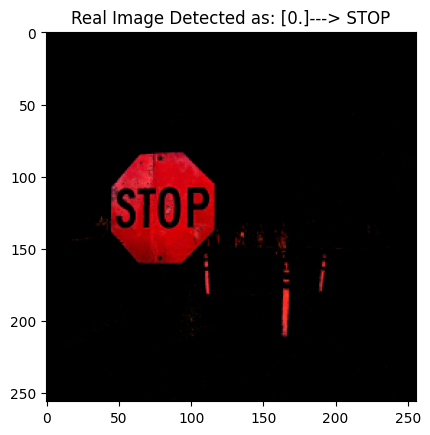

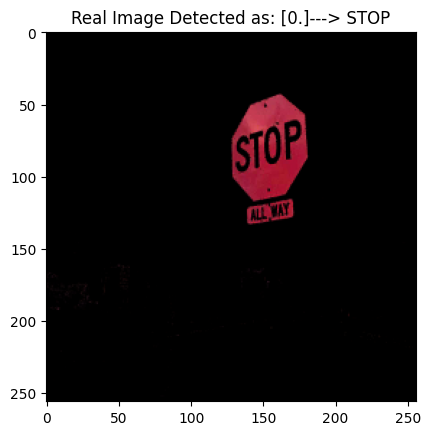

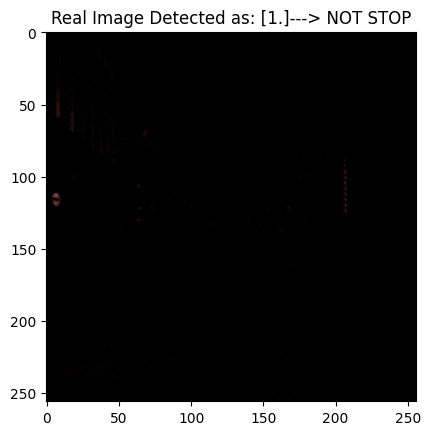

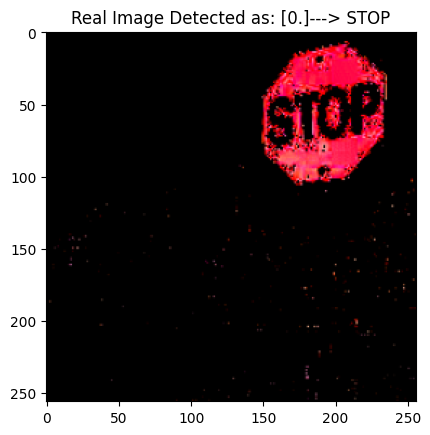

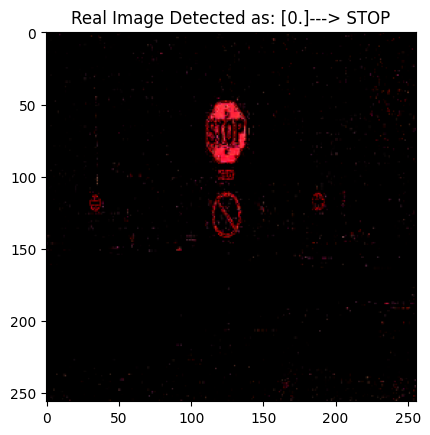

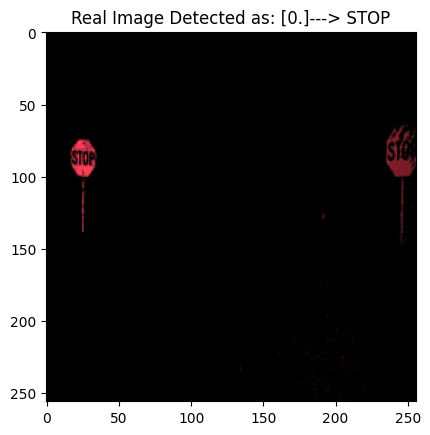

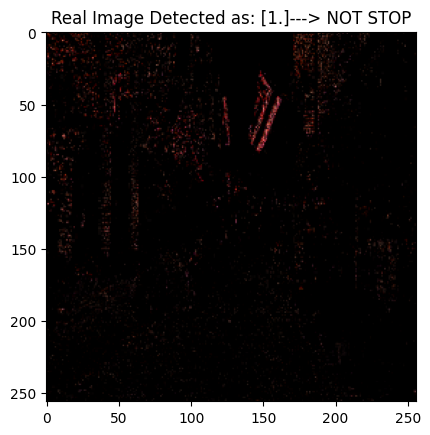

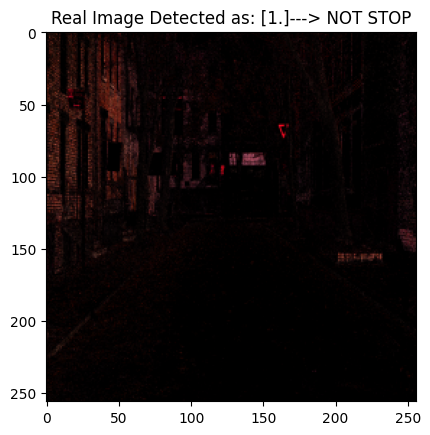

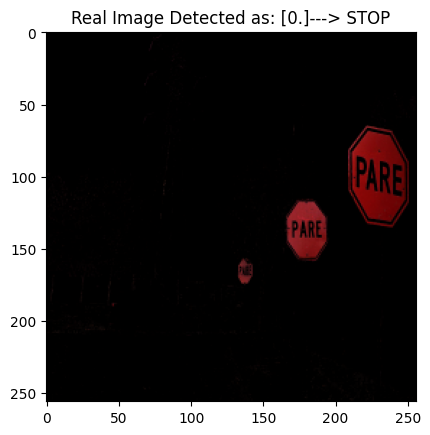

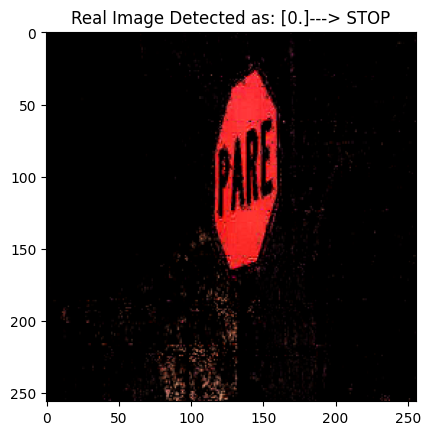

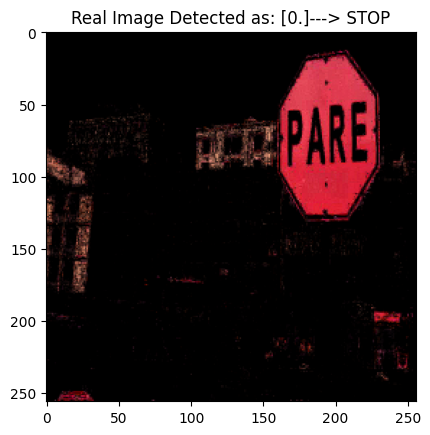

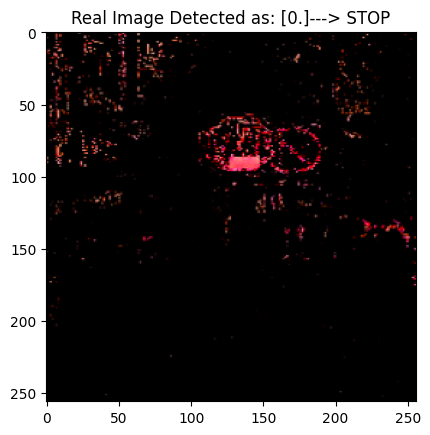

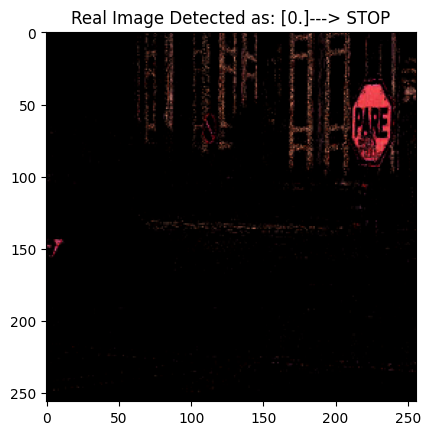

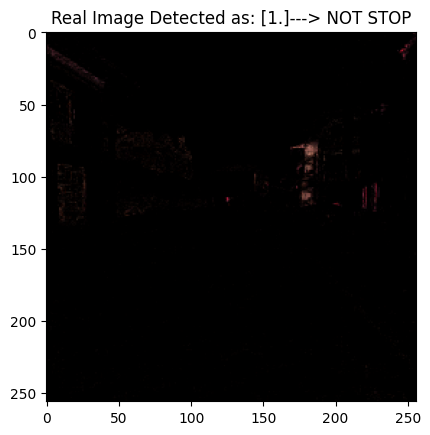

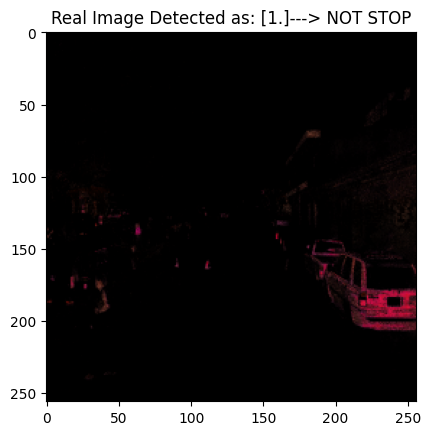

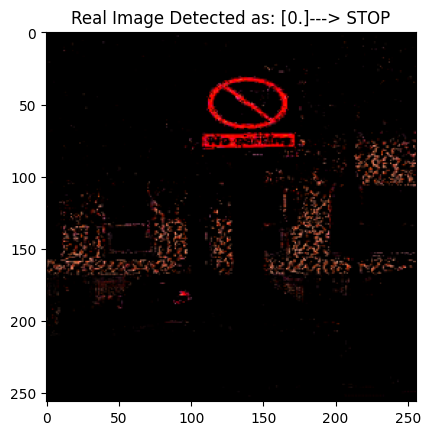

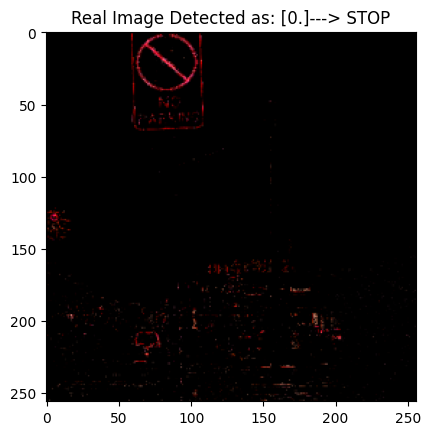

In [33]:
# Iterate and print each new image with its prediction.

for i in range(len(results)):
  plt.imshow(filt_img[i])
  if results[i] == 0:
    plt.title('Real Image Detected as: '+ str(results[i]) + '---> STOP')
  else:
    plt.title('Real Image Detected as: '+ str(results[i]) + '---> NOT STOP')
  plt.show()